## Demo: repeating a subcycle a fixed number of times
The basic steps to set up an OpenCLSim simulation are:
* Import libraries
* Initialise simpy environment
* Define object classes
* Create objects
  * Create sites
  * Create vessels
  * Create activities
* Register processes and run simpy

----

This notebook provides an example of a simulation that takes a number of sub processes, grouped in a sequential activity, that is executed **while a stop condition is not yet met**. But the overall cycle is made up of subcycles that are **executed a fixed number of times**. 

For this example we work with the following sub processes:
* pre cycle activity
* sailing empty
* repeat loading 5 times
  * pre loading activity
  * loading
  * post loading activity
* sailing full
* repeat unloading 5 times
  * pre unloading activity
  * unloading
  * post unloading activity
* post cycle activity

#### 0. Import libraries

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

#### 1. Initialise simpy environment

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [3]:
# create a Site object based on desired mixin classes
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
        core.LoadingFunction,
        core.UnloadingFunction,
    ),
    {},
)

#### 3. Create objects
##### 3.1. Create site object(s)

In [4]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env,
                  "name": "from_site",
                  "geometry": location_from_site,
                  "capacity": 100,
                  "level": 50
                 }
# instantiate from_site 
from_site = Site(**data_from_site)

# prepare input data for to_site
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
data_to_site = {"env": my_env,
                "name": "to_site",
                "geometry": location_to_site,
                "capacity": 50,
                "level": 0
               }
# instantiate to_site 
to_site = Site(**data_to_site)

##### 3.2. Create vessel object(s)

In [5]:
# prepare input data for vessel_01
data_vessel01 = {"env": my_env,
                 "name": "vessel01",
                 "geometry": location_from_site, 
                 "loading_rate": 0.00001,
                 "unloading_rate": 0.00001,
                 "capacity": 5,
                 "compute_v": lambda x: 10
               }
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)

##### 3.3 Create activity/activities

In [6]:
# initialise registry
registry = {}

In [7]:
# create a list of the sub processes: loading
sub_processes =[
    model.BasicActivity(
        env=my_env,
        name="pre loading activity",
        registry=registry,
        duration=100,
        additional_logs=[vessel01],
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="loading",
        registry=registry,
        processor=vessel01,
        origin=from_site,
        destination=vessel01,
        amount=1,
        duration=1000,
    ),
    model.BasicActivity(
        env=my_env,
        name="post loading activity",
        registry=registry,
        duration=100,
        additional_logs=[vessel01],
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity = model.SequentialActivity(
            env=my_env,
            name="sequential_activity_loading_subcycle",
            registry=registry,
            sub_processes=sub_processes,
        )

# create a repeat activity that executes the 'sequential activity' a fixed number of times 
repeat_loading_activity = model.RepeatActivity(
    env=my_env,
    name="repeat_sequential_activity_loading_subcycle",
    registry=registry,
    sub_processes=[sequential_activity],
    repetitions=5
)

In [8]:
# create a list of the sub processes: unloading
sub_processes =[
    model.BasicActivity(
        env=my_env,
        name="pre unloading activity",
        registry=registry,
        duration=100,
        additional_logs=[vessel01],
    ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=to_site,
        amount=1,
        duration=1000,
    ),
    model.BasicActivity(
        env=my_env,
        name="post unloading activity",
        registry=registry,
        duration=100,
        additional_logs=[vessel01],
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity = model.SequentialActivity(
            env=my_env,
            name="sequential_activity_unloading_subcycle",
            registry=registry,
            sub_processes=sub_processes,
        )

# create a repeat activity that executes the 'sequential activity' a fixed number of times 
repeat_unloading_activity = model.RepeatActivity(
    env=my_env,
    name="repeat_sequential_activity_unloading_subcycle",
    registry=registry,
    sub_processes=[sequential_activity],
    repetitions=5
)

In [9]:
# create a list of the sub processes: cycle
sub_processes = [
    model.BasicActivity(
        env=my_env,
        name="pre cycle activity",
        registry=registry,
        duration=100,
        additional_logs=[vessel01],
    ),
    model.MoveActivity(
        env=my_env,
        name="sailing empty",
        registry=registry,
        mover=vessel01,
        destination=from_site,
        duration=500,
    ),
    repeat_loading_activity,
    model.MoveActivity(
        env=my_env,
        name="sailing full",
        registry=registry,
        mover=vessel01,
        duration=500,
        destination=to_site,
    ),
    repeat_unloading_activity,
    model.BasicActivity(
        env=my_env,
        name="post cycle activity",
        registry=registry,
        duration=100,
        additional_logs=[vessel01],
    ),
]

# create a 'sequential activity' that is made up of the 'sub_processes'
sequential_activity = model.SequentialActivity(
    env=my_env,
    name="sequential_activity_subcycle",
    registry=registry,
    sub_processes=sub_processes,
)

# create a while activity that executes the 'sequential activity' while the stop condition is not triggered 
while_activity = model.WhileActivity(
    env=my_env,
    name="while_sequential_activity_subcycle",
    registry=registry,
    sub_processes=[sequential_activity],
    condition_event=[{"type": "container", "concept": to_site, "state": "full"}],
)

#### 4. Register processes and run simpy

In [10]:
model.register_processes([while_activity])
my_env.run()

#### 5. Inspect results
##### 5.1 Inspect logs

In [11]:
plot.get_log_dataframe(vessel01, [while_activity, *sub_processes, sequential_activity])

,Activity,Timestamp,ActivityState,geometry,container level,type,ref
0,pre cycle activity,1970-01-01 00:00:00,START,POINT (4.18055556 52.18664444),0.0,additional log,bf8e31fd-29f3-4252-b96c-3effd73956b0
1,pre cycle activity,1970-01-01 00:01:40,STOP,POINT (4.18055556 52.18664444),0.0,additional log,bf8e31fd-29f3-4252-b96c-3effd73956b0
2,sailing empty,1970-01-01 00:01:40,START,POINT (4.18055556 52.18664444),0.0,NaN,NaN
3,sailing empty,1970-01-01 00:10:00,STOP,POINT (4.18055556 52.18664444),0.0,NaN,NaN
4,12ccac51-3572-4f17-bd7f-a11b66bdf777,1970-01-01 00:10:00,START,POINT (4.18055556 52.18664444),0.0,additional log,12ccac51-3572-4f17-bd7f-a11b66bdf777
...,...,...,...,...,...,...,...
675,a45a3cf6-a60b-4cde-889a-f6dd12e0f47e,1970-01-02 12:36:40,STOP,POINT (4.25222222 52.11428333),0.0,NaN,NaN
676,bd46791d-7171-45d8-892c-91ed3b8f2388,1970-01-02 12:36:40,START,POINT (4.25222222 52.11428333),0.0,additional log,bd46791d-7171-45d8-892c-91ed3b8f2388
677,bd46791d-7171-45d8-892c-91ed3b8f2388,1970-01-02 12:38:20,STOP,POINT (4.25222222 52.11428333),0.0,additional log,bd46791d-7171-45d8-892c-91ed3b8f2388
678,post cycle activity,1970-01-02 12:38:20,START,POINT (4.25222222 52.11428333),0.0,additional log,a9f517a1-742e-4cc5-8496-171ba80f06b4


##### 5.2 Visualise gantt charts

In [12]:
plot.vessel_planning([vessel01, from_site, to_site])

In [13]:
plot.vessel_planning([while_activity, *sub_processes, sequential_activity])

In [14]:
plot.vessel_planning([*sub_processes])

##### 5.3 Visualise container volume developments

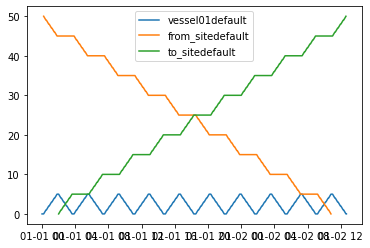

In [15]:
fig = plot.get_step_chart([vessel01, from_site, to_site])

In [16]:
plot.vessel_planning([*sub_processes])